# Fill one day gap in SW_IN

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.fastai import _add_lags_df
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *
from fastai.vision.data import get_grid
from fastcore.foundation import L
from fastcore.transform import *

from meteo_imp.kalman.fastai import show_results
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [ ]:
from ipywidgets import widgets, HBox, VBox
from typing import Sequence

In [ ]:
class InteractiveSequence():
    def __init__(self,s: Sequence, start=0):
        self.s =s
        self.i = start
        self.output = widgets.Output()
        self.button_next = widgets.Button(description="Next", icon="arrow-right")
        self.button_prev = widgets.Button(description="Previous", icon="arrow-left", disabled=True)
        self.button_next.on_click(self.on_next)
        self.button_prev.on_click(self.on_prev)
        self.label = widgets.Label(f"of {len(self.s)-1}")
        self.slider = widgets.IntSlider(start, 0, len(s)-1, 1)
        self.slider.observe(self.on_slide, names="value")
    def update_view(self):
        self.button_enable()
        self.slider.value = self.i
        with self.output:
            display(self.s[self.i])
        self.output.clear_output(wait=True)
    def button_enable(self):
        if self.i < len(self.s) - 1:  self.button_next.disabled = False
        else: self.button_next.disabled = True
        
        if self.i == 0: self.button_prev.disabled = True
        else: self.button_prev.disabled = False
        
    def on_next(self, b):
        self.i +=1
        self.update_view()
    def on_prev(self, b):
        self.i -=1
        self.update_view()
    def on_slide(self, change):
        self.i = change['new']
        self.update_view()
        
    def __call__(self):
        self.update_view()
        display(VBox([HBox([self.slider, self.label]), HBox([self.button_prev, self.button_next])]), self.output)

In [ ]:
reset_seed()

In [ ]:
hai = pd.read_parquet(hai_path64)
hai_era = pd.read_parquet(hai_era_path64)

<AxesSubplot: xlabel='time'>

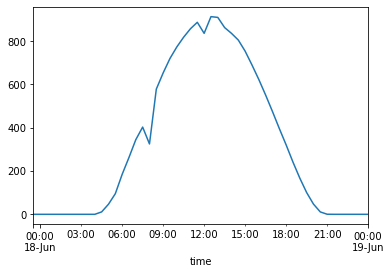

In [ ]:
hai[8_110:8_160].SW_IN.plot()

In [ ]:
df = hai[8_110-80:8_160+80]
control = _add_lags_df(hai_era.loc[df.index], 1)

<AxesSubplot: xlabel='time'>

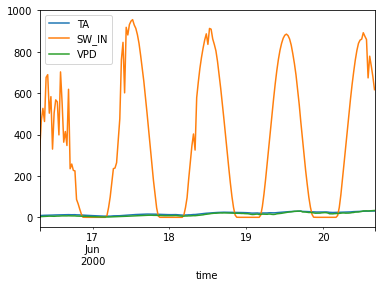

In [ ]:
df.plot()

<AxesSubplot: xlabel='time'>

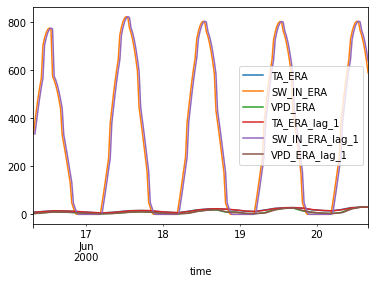

In [ ]:
control.plot()

In [ ]:
df.columns

Index(['TA', 'SW_IN', 'VPD'], dtype='object')

In [ ]:
mask = df.astype(dtype=bool)
mask.iloc[:,:] = True
mask.iloc[100:115, 1] = False

In [ ]:
mask.sum(0)

TA       210
SW_IN    195
VPD      210
dtype: int64

In [ ]:
pipe = Pipeline([MeteoImpDf2Tensor, MeteoImpNormalize(*get_stats(df), *get_stats(control)), ToTuple])

In [ ]:
pipe[1]

MeteoImpNormalize -- {'mean_data': tensor([ 18.2214, 355.5345,  13.8018], dtype=torch.float64), 'std_data': tensor([  7.3713, 336.5250,   8.4760], dtype=torch.float64), 'mean_control': tensor([ 16.4072, 325.8798,  10.0621,  16.3431, 324.6188,   9.9632],
       dtype=torch.float64), 'std_control': tensor([  6.5264, 307.3572,   7.4125,   6.4755, 307.5501,   7.2901],
       dtype=torch.float64)}:
encodes: (MeteoImpTensor,object) -> encodes
decodes: (MeteoImpTensor,object) -> decodes
(NormalsParams,object) -> decodes

In [ ]:
data = MeteoImpDf(df, mask, control)

In [ ]:
input, targ = pipe(data)

input = input[0].unsqueeze(0), input[1].unsqueeze(0), input[2].unsqueeze(0), 

targ = targ[0].unsqueeze(0), targ[1].unsqueeze(0), targ[2].unsqueeze(0), 

In [ ]:
# input[0][~input[1]] = torch.nan 

In [ ]:
k = KalmanFilter.init_local_slope_pca(3,3, df)

In [ ]:
k

state,x_0,x_1,x_2,x_3,x_4,x_5
x_0,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000
x_1,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
x_2,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
x_3,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
x_4,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
x_5,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
state,x_0,x_1,x_2,x_3,x_4,x_5
x_0,0.1000,0.0000,0.0000,0.0000,0.0000,0.0000
x_1,0.0000,0.1000,0.0000,0.0000,0.0000,0.0000
x_2,0.0000,0.0000,0.1000,0.0000,0.0000,0.0000


In [ ]:
pred = k(input)

In [ ]:
loss_f = KalmanLoss(only_gap=True)
loss_f_all = KalmanLoss(only_gap=False)

In [ ]:
loss_f(pred, targ) 

tensor(15.7478, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
pipe1 = Pipeline(pipe.fs[-2,-1])

In [ ]:
pipe1

Pipeline: MeteoImpNormalize -- {'mean_data': tensor([ 18.2214, 355.5345,  13.8018], dtype=torch.float64), 'std_data': tensor([  7.3713, 336.5250,   8.4760], dtype=torch.float64), 'mean_control': tensor([ 16.4072, 325.8798,  10.0621,  16.3431, 324.6188,   9.9632],
       dtype=torch.float64), 'std_control': tensor([  6.5264, 307.3572,   7.4125,   6.4755, 307.5501,   7.2901],
       dtype=torch.float64)} -> ToTuple

In [ ]:
def plot_pred(pred, data, control=True):
    pred_dec = preds2df([pipe.decode(pred)], [data])[0]

    data_pred = pd.merge(data.tidy(hai_control), pred_dec.tidy(), on=["time", "variable"])

    # title = [f"loss: {loss.item():.6f}"] + [format_metric(name, val) for name, val in metrics.items()]
    return plot_variable(data_pred, variable="SW_IN", ys=["value", "mean", "control"], error=True, control=control)

In [ ]:
plot_pred(pred, data)

alt.LayerChart(...)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
def train(k, data_gen, loss_f, n_iter, lr, control=True):
    k.train()
    data, input, targ = data_gen
    optimizer = torch.optim.Adam(k.parameters(), lr=lr) 

    t_info = pd.DataFrame(columns=['loss', 'rmse_gap', 'rmse', 'plot'])
    pd.DataFrame({k: pd.Series(dtype=t) for k, t in [('loss', float), ('rmse_gap', float), ('rmse', float), ('plot', object)]})
    for i in tqdm(range(n_iter)):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        pred= k(input)
        loss = loss_f(pred, targ)
        t_info.loc[i, 'loss'] = loss_f(pred, targ).item()
        t_info.loc[i, 'loss_all'] = loss_f_all(pred, targ).item()
        t_info.loc[i, 'rmse_gap'] = rmse_gap(pred, targ)
        t_info.loc[i, 'rmse'] = rmse_mask(pred, targ)
        t_info.loc[i, 'plot'] = plot_pred(pred, data, control)
        # backpropagate gradients
        loss.backward()
        optimizer.step()
    return t_info

In [ ]:
def data_gen_one_gap(df, g_inter, df_control, device='cpu', all_gap=False):
    control = _add_lags_df(df_control.loc[df.index], 1)
    mask = df.astype(dtype=bool)
    mask.iloc[:,:] = True
    col_sel = [0,1,2] if all_gap else 1
    mask.iloc[g_inter[0]:g_inter[1], col_sel] = False 
    pipe = Pipeline([MeteoImpDf2Tensor, MeteoImpNormalize(*get_stats(df), *get_stats(control)), ToTuple])
    data = MeteoImpDf(df, mask, control)
    input, targ = pipe(data)
    input = input[0].unsqueeze(0).to(device), input[1].unsqueeze(0).to(device), input[2].unsqueeze(0).to(device), 
    targ = targ[0].unsqueeze(0).to(device), targ[1].unsqueeze(0).to(device), targ[2].unsqueeze(0).to(device), 
    return data, input, targ

In [ ]:
def plot_train_info(t_info):
    ax = get_grid(4,2,2, figsize=(8,6))

    t_info.loss.plot(ax=ax[0], title="loss gap")
    t_info.loss_all.plot(ax=ax[1], title="loss all")
    t_info.rmse.plot(ax=ax[2], title="rmse")
    t_info.rmse_gap.plot(ax=ax[3], title="rmse gap")
    
    InteractiveSequence(t_info['plot'], start=len(t_info)-1)()

### Loss gap

In [ ]:
data_gen0 = data_gen_one_gap(hai[8_110-80:8_160+80], (95, 120), hai_era )

  0%|          | 0/40 [00:00<?, ?it/s]

Output()

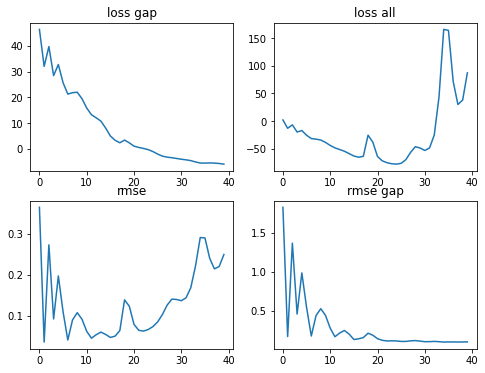

In [ ]:
k0 = KalmanFilter.init_local_slope_pca(3,3, None)
t_info0 = train(k0, data_gen0, loss_f, 4t0, 1e-2)
plot_train_info(t_info0)

In [ ]:
k = KalmanFilter.init_local_slope_pca(3,3, None)
t_info = train(k, (data, input, targ), loss_f, 40, 1e-2)

  0%|          | 0/40 [00:00<?, ?it/s]

<AxesSubplot: title={'center': 'rmse gap'}>

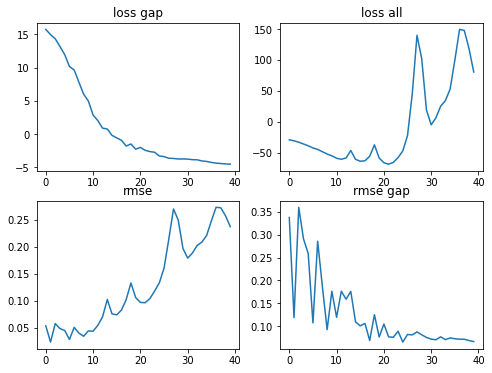

In [ ]:
ax = get_grid(4,2,2, figsize=(8,6))

t_info.loss.plot(ax=ax[0], title="loss gap")
t_info.loss_all.plot(ax=ax[1], title="loss all")
t_info.rmse.plot(ax=ax[2], title="rmse")
t_info.rmse_gap.plot(ax=ax[3], title="rmse gap")

In [ ]:
InteractiveSequence(t_info['plot'])()

Output()

### Loss not gap

In [ ]:
k = KalmanFilter.init_local_slope_pca(3,3, df)
t_info_all = train(k, loss_f_all, 00)

TypeError: train() missing 2 required positional arguments: 'n_iter' and 'lr'

<AxesSubplot: title={'center': 'rmse gap'}>

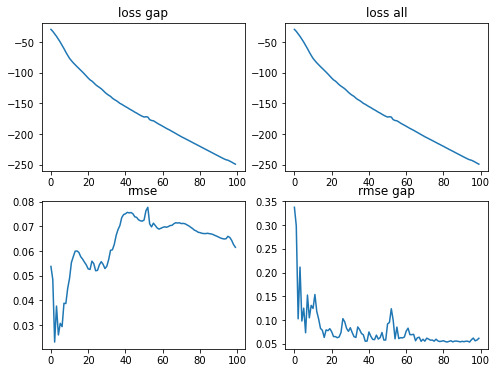

In [ ]:
ax = get_grid(4,2,2, figsize=(8,6))

t_info_all.loss.plot(ax=ax[0], title="loss gap")
t_info_all.loss_all.plot(ax=ax[1], title="loss all")
t_info_all.rmse.plot(ax=ax[2], title="rmse")
t_info_all.rmse_gap.plot(ax=ax[3], title="rmse gap")

In [ ]:
int_s = InteractiveSequence(t_info_all['plot'])()

Output()

In [ ]:
k

state,x_0,x_1,x_2,x_3,x_4,x_5
x_0,1.2977,-0.0050,0.0446,0.6500,-0.1277,-0.0619
x_1,0.1847,1.3479,-0.1871,-0.1503,0.5598,0.0960
x_2,0.1825,-0.0310,1.4431,-0.0475,0.0819,0.5295
x_3,0.1796,0.0517,-0.0185,1.2563,-0.0411,-0.1260
x_4,-0.1511,0.0151,-0.1012,0.1421,1.2565,0.0956
x_5,-0.0133,-0.0707,0.0052,0.1753,-0.0608,1.0677
state,x_0,x_1,x_2,x_3,x_4,x_5
x_0,0.0347,0.0011,-0.0098,0.0215,0.0097,0.0134
x_1,0.0011,0.0050,0.0025,-0.0008,0.0062,0.0056
x_2,-0.0098,0.0025,0.0045,-0.0078,-0.0008,-0.0010


### Bigger gap

In [ ]:
data_gen = data_gen_one_gap(hai[8_110-80:8_160+80], (95, 120), hai_era )

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

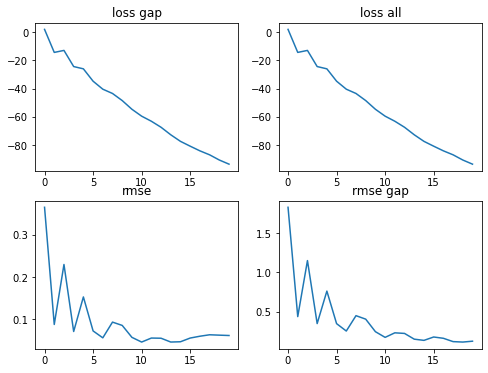

In [ ]:
k2 = KalmanFilter.init_local_slope_pca(3,3, None)
t_info2 = train(k2, data_gen, loss_f_all, 20, 1e-2)
plot_train_info(t_info2)

In [ ]:
t_data_gen = data_gen_one_gap(hai[8_110-80:8_160+80], (120, 130), hai_era )
plot_pred(k2(t_data_gen[1]), t_data_gen[0])

alt.LayerChart(...)

In [ ]:
k2

state,x_0,x_1,x_2,x_3,x_4,x_5
x_0,1.1488,0.1318,0.0117,0.8294,0.0579,0.0394
x_1,-0.0694,1.0401,-0.0690,-0.0152,0.8974,0.0485
x_2,-0.0035,0.1165,1.1399,0.0882,0.1157,0.8688
x_3,0.0019,-0.0930,0.0165,1.1456,0.0597,0.0641
x_4,-0.0392,0.0136,-0.0292,-0.0728,1.0049,-0.0712
x_5,0.0152,-0.1065,-0.0113,0.0561,0.0680,1.1262
state,x_0,x_1,x_2,x_3,x_4,x_5
x_0,0.0435,0.0198,0.0202,0.0338,-0.0226,0.0008
x_1,0.0198,0.0564,0.0327,0.0119,0.0281,0.0555
x_2,0.0202,0.0327,0.0351,-0.0086,-0.0188,0.0315


  0%|          | 0/20 [00:00<?, ?it/s]

Output()

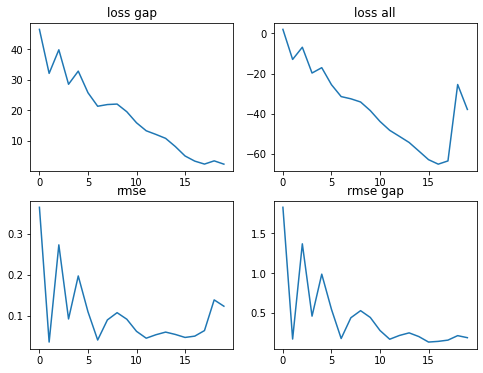

In [ ]:
k2 = KalmanFilter.init_local_slope_pca(3,3, None)
t_info2 = train(k2, data_gen, loss_f, 20, 1e-2)
plot_train_info(t_info2)

### 1 day of gap

In [ ]:
data_gen3 = data_gen_one_gap(hai[8_110-80:8_160+80], (80, 150), hai_era )

In [ ]:
k3 = KalmanFilter.init_local_slope_pca(3,3, None)
train(k3, data_gen3, loss_f_all, 5, 1e-2) # get to decent parameters
# k3.trans_cov = k3.trans_cov * 0.01
t_info3 = train(k3, data_gen3, loss_f_all, 40, 1e-2)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Output()

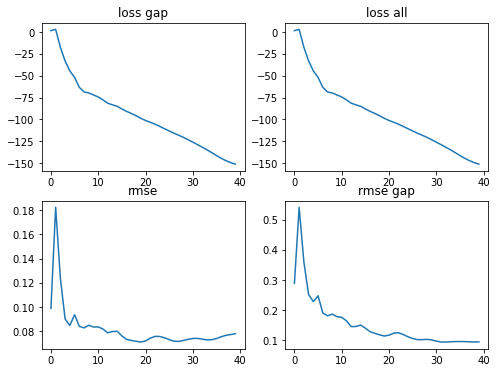

In [ ]:
plot_train_info(t_info3)

In [ ]:
t_info3.iloc[-2:-1]

,loss,rmse_gap,rmse,plot,loss_all
38,-123.996457,0.13724,0.082401,alt.LayerChart(...),-123.996457


In [ ]:
k3

state,x_0,x_1,x_2,x_3,x_4,x_5
x_0,1.1488,0.1318,0.0117,0.8294,0.0579,0.0394
x_1,-0.0694,1.0401,-0.0690,-0.0152,0.8974,0.0485
x_2,-0.0035,0.1165,1.1399,0.0882,0.1157,0.8688
x_3,0.0019,-0.0930,0.0165,1.1456,0.0597,0.0641
x_4,-0.0392,0.0136,-0.0292,-0.0728,1.0049,-0.0712
x_5,0.0152,-0.1065,-0.0113,0.0561,0.0680,1.1262
state,x_0,x_1,x_2,x_3,x_4,x_5
x_0,0.0435,0.0198,0.0202,0.0338,-0.0226,0.0008
x_1,0.0198,0.0564,0.0327,0.0119,0.0281,0.0555
x_2,0.0202,0.0327,0.0351,-0.0086,-0.0188,0.0315


In [ ]:
k0.trans_cov, k3.trans_cov

(tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000]], dtype=torch.float64,
        grad_fn=<AddBackward0>),
 tensor([[ 0.0078,  0.0039,  0.0089,  0.0073, -0.0016, -0.0008],
         [ 0.0039,  0.0145,  0.0031,  0.0098, -0.0030,  0.0138],
         [ 0.0089,  0.0031,  0.0131,  0.0071,  0.0011, -0.0003],
         [ 0.0073,  0.0098,  0.0071,  0.0125, -0.0059,  0.0101],
         [-0.0016, -0.0030,  0.0011, -0.0059,  0.0163, -0.0110],
         [-0.0008,  0.0138, -0.0003,  0.0101, -0.0110,  0.0318]],
        dtype=torch.float64, grad_fn=<AddBackward0>))

In [ ]:
k0.trans_matrix, k3.trans_matrix

(Parameter containing:
 tensor([[1., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[ 1.0086,  0.0641, -0.0050,  1.0275, -0.0139,  0.0290],
         [-0.0564,  1.0605, -0.0554,  0.0049,  1.0635, -0.0571],
         [ 0.0377,  0.0598,  1.0373,  0.0907, -0.0394,  1.0221],
         [ 0.0103,  0.1001,  0.0120,  0.9910,  0.0585,  0.0319],
         [ 0.0513,  0.0618,  0.0555, -0.0553,  0.9462, -0.0534],
         [-0.0606,  0.0597, -0.0501,  0.0845,  0.0556,  1.1050]],
        dtype=torch.float64, requires_grad=True))

In [ ]:
k0 = KalmanFilter.init_local_slope_pca(3,3, None)
def par_diff(k0, k1):
    out = {}
    for (n,p0), (_,p1) in zip(k0.named_parameters(), k1.named_parameters()):
        out[n] = (p0-p1).abs().mean().detach().item()
    return pd.DataFrame(out,index=[0])

In [ ]:
par_diff(k0, k3)

,trans_matrix,trans_off,trans_cov_raw,contr_matrix,obs_matrix,obs_off,obs_cov_raw,init_state_mean,init_state_cov_raw
0,0.080702,0.013349,0.079071,0.047649,0.108142,0.073074,0.457733,0.159152,0.249438


In [ ]:
par_diff(k2, k3)

,trans_matrix,trans_off,trans_cov_raw,contr_matrix,obs_matrix,obs_off,obs_cov_raw,init_state_mean,init_state_cov_raw
0,0.077905,0.018252,0.070294,0.057594,0.09894,0.085995,0.257732,0.148817,0.109384


In [ ]:
par_diff(k0, k2)

,trans_matrix,trans_off,trans_cov_raw,contr_matrix,obs_matrix,obs_off,obs_cov_raw,init_state_mean,init_state_cov_raw
0,0.069312,0.00665,0.087398,0.030413,0.090035,0.012921,0.200001,0.140695,0.183713


### Gap in all variables

In [ ]:
data_gen_gall = data_gen_one_gap(hai[8_110-80:8_160+80], (90, 130), hai_era, all_gap=True)

In [ ]:
k_gall = KalmanFilter.init_local_slope_pca(3,3)

In [ ]:
t_info_gall = train(k_gall, data_gen_gall, loss_f_all, 40, 1e-2)

  0%|          | 0/40 [00:00<?, ?it/s]

AssertionError: 

In [ ]:
plot_train_info(t_info_gall)

## Random Init

In [ ]:
data_gen4 = data_gen_one_gap(hai[8_110-80:8_160+80], (80, 150), hai_era)

In [ ]:
k4 = KalmanFilter.init_random(3,3,6, dtype=torch.float64)

In [ ]:
t_info4 = train(k4, data_gen4, loss_f_all, 100, 1e-2)

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

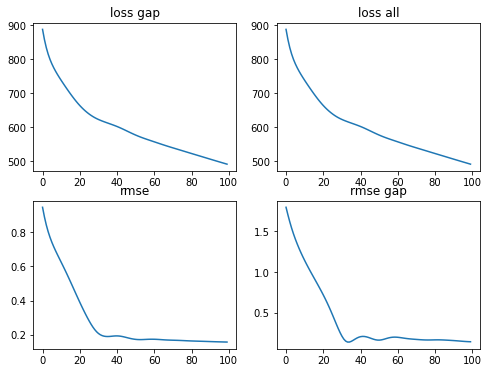

In [ ]:
plot_train_info(t_info4)

In [ ]:
t_info4 = train(k4, data_gen4, loss_f_all, 100, 3e-2)

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

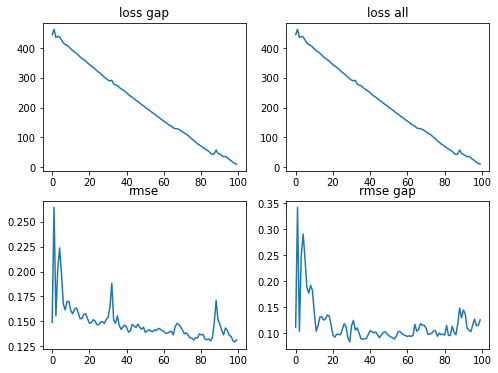

In [ ]:
plot_train_info(t_info4)

In [ ]:
k4

Kalman Filter
        N dim obs: 3, N dim state: 3, N dim contr: 6

## Small state

### Local slope init

In [ ]:
data_gen_sls = data_gen_one_gap(hai[8_110-80:8_160+80], (80, 150), hai_era)

In [ ]:
k_sls = KalmanFilter.init_local_slope_pca(3,1, hai)

In [ ]:
t_info_sls = train(k_sls, data_gen_sls, loss_f_all, 70, 2e-2)

  0%|          | 0/70 [00:00<?, ?it/s]

Output()

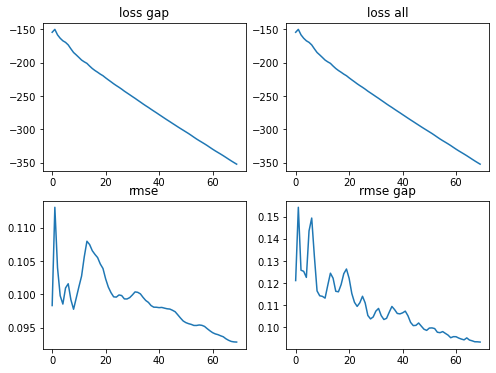

In [ ]:
plot_train_info(t_info_sls)

### Random

In [ ]:
data_gen5 = data_gen_one_gap(hai[8_110-80:8_160+80], (80, 150), hai_era)

In [ ]:
k5 = KalmanFilter.init_random(3,1,6, dtype=torch.float64)

In [ ]:
t_info5 = train(k5, data_gen5, loss_f_all, 200, 2e-2)

  0%|          | 0/200 [00:00<?, ?it/s]

Output()

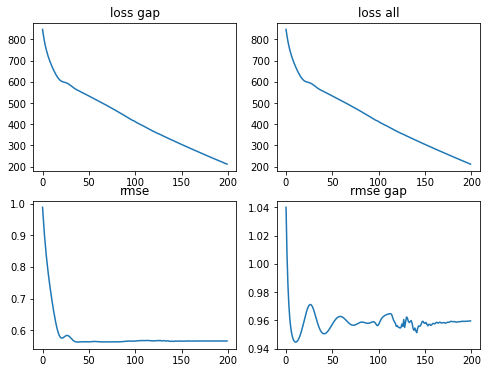

In [ ]:
plot_train_info(t_info5)

In [ ]:
t_info5 = train(k5, data_gen5, loss_f_all, 200, 2e-2)

  0%|          | 0/200 [00:00<?, ?it/s]

Output()

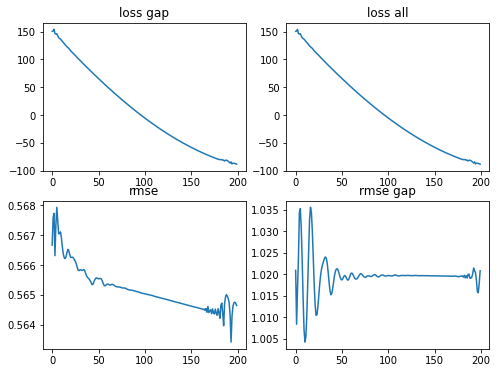

In [ ]:
plot_train_info(t_info5)

In [ ]:
t_info5 = train(k5, data_gen5, loss_f_all, 500, 2e-2)

  0%|          | 0/500 [00:00<?, ?it/s]

Output()

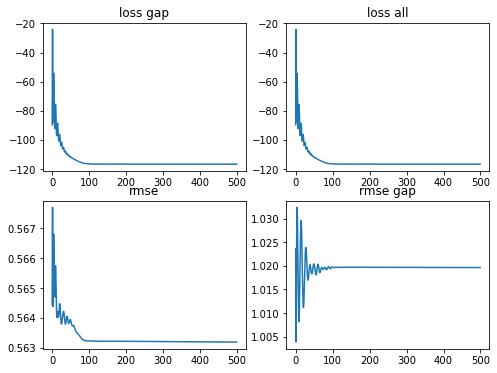

In [ ]:
plot_train_info(t_info5)

In [ ]:
t_info5 = train(k5, data_gen4, loss_f_all, 100, 3e-2)

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

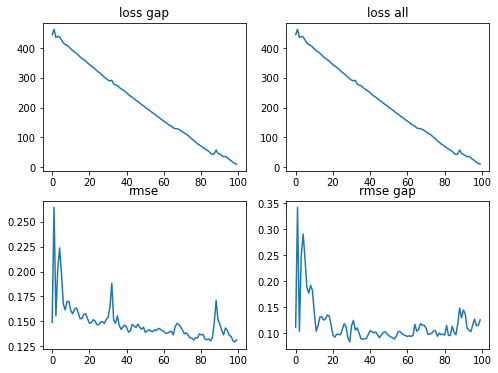

In [ ]:
plot_train_info(t_info5)

In [ ]:
k4

Kalman Filter
        N dim obs: 3, N dim state: 3, N dim contr: 6

## Filter only

In [ ]:
data_gen6 = data_gen_one_gap(hai[8_110-80:8_160+80], (95, 120), hai_era )

In [ ]:
k6 = KalmanFilter.init_local_slope_pca(3,3, None)
k6.use_smooth = False
# train(k6, data_gen6, loss_f_all, 5, 1e-2) # get to decent parameters
# k3.trans_cov = k3.trans_cov * 0.01
t_info6 = train(k6, data_gen5, loss_f_all, 25, 1e-2)

  0%|          | 0/25 [00:00<?, ?it/s]

Output()

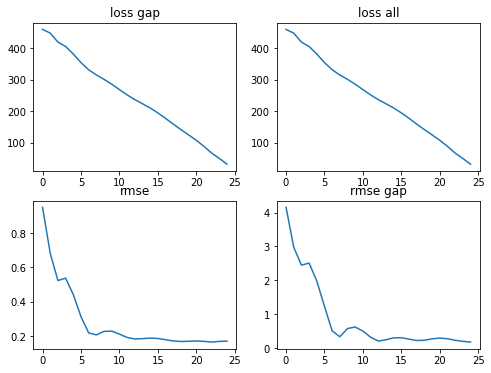

In [ ]:
plot_train_info(t_info6)

## No Control

### Gap in SW_IN only

In [ ]:
data_gen_nc = data_gen_one_gap(hai[8_110-80:8_160+80], (80, 150), hai_era.sample(frac=1).reset_index(drop=True).set_index(hai_era.index) )

/tmp/ipykernel_55400/2861280523.py:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  mask.loc[g_inter[0]:g_inter[1], gap_var] = False


In [ ]:
k_nc = KalmanFilter.init_local_slope_pca(3,3, None, use_control=False)
# k3.trans_cov = k3.trans_cov * 0.01
t_info_nc = train(k_nc, data_gen_nc, loss_f_all, 20, 1e-2)

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

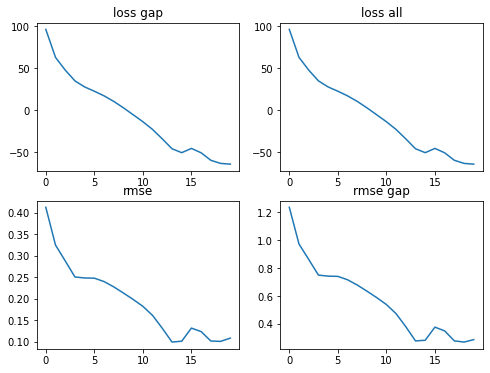

In [ ]:
plot_train_info(t_info_nc)

In [ ]:
data, input, targ = data_gen_nc

In [ ]:
t_data_g = data_gen_one_gap(hai[8_110-80:8_160+80], (120, 200), hai_era) 

In [ ]:
plot_pred(k_nc(t_data_g[1]), t_data_g[0])

alt.LayerChart(...)

### Gap all variables

In [ ]:
data_gen_nc2 = data_gen_one_gap(hai[8_110-80:8_160+80], (95, 105),
                               hai_era,#.sample(frac=1).reset_index(drop=True).set_index(hai_era.index),
                              all_gap=True)

In [ ]:
k_nc2 = KalmanFilter.init_local_slope_pca(3,3, None, use_control=False)
# k3.trans_cov = k3.trans_cov * 0.01
t_info_nc2 = train(k_nc2, data_gen_nc2, loss_f_all, 20, 1e-2)

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

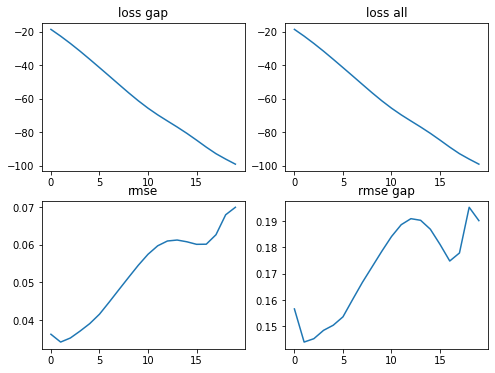

In [ ]:
plot_train_info(t_info_nc2)

In [ ]:
data_gen_nc3 = data_gen_one_gap(hai[8_110-80:8_160+80], (90, 130),
                               hai_era.sample(frac=1).reset_index(drop=True).set_index(hai_era.index),
                              all_gap=True)

In [ ]:
k_nc3 = KalmanFilter.init_local_slope_pca(3,3,None, use_control=False)
# k3.trans_cov = k3.trans_cov * 0.01
t_info_nc3 = train(k_nc3, data_gen_nc3, loss_f_all, 20, 1e-2, control=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

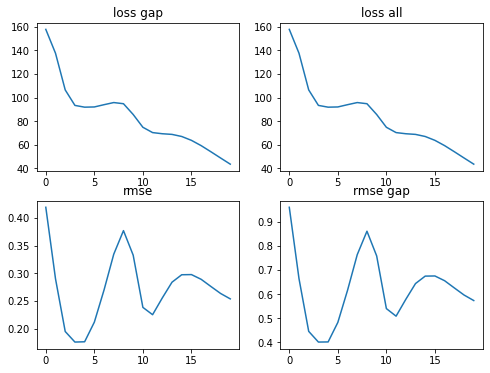

In [ ]:
plot_train_info(t_info_nc3)